# Predictions using Gensim doc2vec and Logistic regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
import sklearn.ensemble
import statistics

pd.set_option('display.max_rows', 4)

In [ ]:
# !date

# %load_ext autoreload
# %autoreload 2

    Load the dataset and create a corpus text

In [2]:
messages_df = pd.read_excel("C:/Users/user/UW/keshet - mwach_interaction/SMSdata/mwachNeo/allSMSdatabase/messages_export_2019-03-05.xlsx")
messages_df

,mid,pid,day,timestamp,auto,external,delta_human,delta,delta_last,study_wk,edd_wk,chars,words,topic,related,sent_by,language,translated,original
0,808,15,Tue,2017-12-05 06:36:59.614,signup.two-way.normal.0,Success,NaN,NaN,NaN,0.000000,-9.000000,250,42,NaN,NaN,system,swahili,Welcome to Mobile WACh NEO! Good job coming in...,Karibu kwa Mobile WACh NEO. Kazi nzuri kwa kuj...
1,859,15,Tue,2017-12-05 06:55:45.982,NaN,NaN,18m,1.126367e+03,NaN,0.000000,-9.000000,30,4,validation,1.0,participant,english,NaN,Validation Code Correct: 13514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59504,56843,800,Sun,2018-07-15 17:05:23.401,edd.two-way.normal.14,Failed,NaN,NaN,NaN,8.714286,2.000000,252,41,42 weeks,NaN,system,swahili,"{name}, this is {nurse} from {clinic} Bad swel...","Linet, huyu ni Mercy kutoka Rachuonyo. kufura ..."
59505,67270,800,Mon,2019-02-04 06:31:09.703,NaN,Failed,258d 20h 7m,2.236368e+07,NaN,37.857143,31.142857,354,58,NaN,NaN,nurse,NaN,"{name}, this is {nurse} from {clinic}. Thank y...","Linet, huyu ni Mercy kutoka kwa Rachuonyo. Asa..."


In [3]:
#Load participant data
p_data = pd.io.stata.read_stata('C:/Users/user/UW/keshet - mwach_interaction/ParticipantData/mwachNeo/NEO_Enrollment_Interview.dta')
p_data

,today,start,end,site_hand,group1studyid_p2,ptidno,studyid_p2re,group3en_scrid_site,group3en_scrid_id,en_scrid,...,ip_afraid,comment,metainstanceID,group17te_topuphow5,te_topuphow_sp,te_simnum,te_carrier,en_planafterdel,en_whereafterdel,en_whereafterdel_sp
0,2017-12-05,12-5-17 7:58,12-5-17 8:20,Mathare,1,42110001,1,Mathare,17,Nov-17,...,No,ENROLLED SUCCESSFULLY,uuid:49ab8466-159d-4513-9e21-ae9353de78b3,NaN,,NaN,NaN,NaN,NaN,NaN
1,2017-12-05,12-5-17 8:30,12-5-17 8:39,Mathare,2,42110002,2,Rachuonyo,18,46-18,...,No,ENROLLED SUCCESSFULLY,uuid:4e82e0d9-6882-4e18-8028-ae60d1deec6a,NaN,,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2018-05-15,5-15-18 9:04,5-15-18 9:14,Rachuonyo,799,42460799,799,Rachuonyo,865,46-865,...,No,Enrolled,uuid:6e73839b-6494-478e-9dad-5252216f2e16,NaN,,2.0,Safaricom,Yes,NaN,NaN
797,2018-05-15,5-15-18 9:40,5-15-18 9:49,Rachuonyo,800,42460800,800,Rachuonyo,1054,46-1054,...,No,Enrolled,uuid:65ca53ad-ab4a-44a1-b93e-97ae0156909d,NaN,,2.0,Safaricom,Yes,NaN,NaN


In [ ]:
for col in p_data.columns: 
    print(col) 

In [4]:
# age in years as continuous outcome to predict
messages_df['system_msg'] = (messages_df['sent_by']=='system')

In [5]:
#We need to know number of responses each system message received. --- we will come back later to remove nurse messages
messages_df['msg_group'] = messages_df.system_msg.cumsum()
messages_df.msg_group.value_counts()

7115     190
24446     39
        ... 
17924      1
2047       1
Name: msg_group, Length: 26021, dtype: int64

In [6]:
#Our responses vector is all those messages with a value count of more than 1
response = (messages_df.msg_group.value_counts() > 1)#Creating the systemMessage DataFrame to define our features.
systemMesaagesDF = messages_df[messages_df.sent_by == "system"]
systemMesaagesDF = systemMesaagesDF.set_index('msg_group')
systemMesaagesDF['response'] = response
systemMesaagesDF['swahili'] = systemMesaagesDF.language == 'swahili'
systemMesaagesDF['english'] = systemMesaagesDF.language == 'english'
systemMesaagesDF['luo'] = systemMesaagesDF.language == 'luo'
systemMesaagesDF.shape

(26021, 24)

In [7]:
#Let's now filter the columns and convert them to float.
X = systemMesaagesDF.filter(['edd_wk', 'chars', 'words', 'swahili', 'english', 'luo']).astype(np.float)
y = systemMesaagesDF.response.astype(np.float)
# convert to numpy arrays (pandas and sklearn don't always work together well)
y = y.values

In [8]:
#Lets create our text corpus
X_text = systemMesaagesDF.original.astype('str')
corpus = X_text.values
corpus

array(['Karibu kwa Mobile WACh NEO. Kazi nzuri kwa kuja kwa ziara yako ya kliniki! Utapokea SMS kila wiki ambayo itakusaidia wakati wa ujauzito na miaka mbili za kwanza za maisha ya mtoto wako.Tafadhali tutumie SMS na uuulize maswali au mashaka yoyote unayo.',
       'Mama Lucas, huyu ni Brenda kutoka Mathare. Wakati mwingine matatizo hutokea wakati unaumwa na wakati wa kujifungua, kama kutokwa na damu au mishtuko ya kifafa , ambayo yanahitaji wafanyakazi wa afya wenye ujuzi, dawa na vifaa vya kutibu. Bila matibabu hayo, mama na mtoto wanaweza kufariki. Kwa hivyo ni salama kabisa kujifungua katika kituo ambacho kinaweza kushughulikia matatizo haya na mengine zaidi. Utafikaje kwenye kituo?',
       'Mama Lucas, huyu ni Brenda kutoka Mathare. kufura vibaya kwa mikono na uso au kuumwa vibaya na kichwa ni ishara ya shida. Ambia familia yako wakupeleke kliniki wakiona haya. Umekuwa na kufura yoyote au kuumwa na kichwa kwa huu ujauzito? Zinaendelea kuzidi?',
       ...,
       'Linet, huyu n

In [9]:
y

array([1., 1., 1., ..., 0., 0., 1.])

In [10]:
# instead of encoding the text data with an n-gram, in this notebook we will use doc2vec to embed the
# text in a high-dimensional vector

# see https://radimrehurek.com/gensim/models/doc2vec.html for documentation

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [11]:
# tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(data)]

documents = [TaggedDocument(doc.lower(), [i]) for i, doc in enumerate(X_text)]

In [12]:
documents

[TaggedDocument(words='karibu kwa mobile wach neo. kazi nzuri kwa kuja kwa ziara yako ya kliniki! utapokea sms kila wiki ambayo itakusaidia wakati wa ujauzito na miaka mbili za kwanza za maisha ya mtoto wako.tafadhali tutumie sms na uuulize maswali au mashaka yoyote unayo.', tags=[0]),
 TaggedDocument(words='mama lucas, huyu ni brenda kutoka mathare. wakati mwingine matatizo hutokea wakati unaumwa na wakati wa kujifungua, kama kutokwa na damu au mishtuko ya kifafa , ambayo yanahitaji wafanyakazi wa afya wenye ujuzi, dawa na vifaa vya kutibu. bila matibabu hayo, mama na mtoto wanaweza kufariki. kwa hivyo ni salama kabisa kujifungua katika kituo ambacho kinaweza kushughulikia matatizo haya na mengine zaidi. utafikaje kwenye kituo?', tags=[1]),
 TaggedDocument(words='mama lucas, huyu ni brenda kutoka mathare. kufura vibaya kwa mikono na uso au kuumwa vibaya na kichwa ni ishara ya shida. ambia familia yako wakupeleke kliniki wakiona haya. umekuwa na kufura yoyote au kuumwa na kichwa kwa hu

In [ ]:
# max_epochs = 100
# vec_size = 20
# alpha = 0.025

# model = Doc2Vec(size=vec_size,
#                 alpha=alpha, 
#                 min_alpha=0.00025,
#                 min_count=1,
#                 dm =1)
  
# model.build_vocab(tagged_data)

# for epoch in range(max_epochs):
#     print('iteration {0}'.format(epoch))
#     model.train(tagged_data,
#                 total_examples=model.corpus_count,
#                 epochs=model.iter)
#     # decrease the learning rate
#     model.alpha -= 0.0002
#     # fix the learning rate, no decay
#     model.min_alpha = model.alpha

# model.save("d2v.model")
# print("Model Saved")

In [33]:
# %%time
model = Doc2Vec(documents, vector_size=10, window=2, min_count=1, workers=4, max_epochs = 100)

In [14]:
vector = model.infer_vector([X_text[1]])
vector
#print(X_text[1])

array([ 1.58131679e-05, -2.14765809e-04,  4.62909724e-04, -4.67977283e-04,
       -7.76888191e-06,  4.05002793e-04,  9.12208852e-05,  9.82314014e-05,
        3.11282638e-04, -2.97523162e-04,  5.93603909e-05, -4.79782495e-04,
       -4.23902879e-04, -2.36980472e-04, -6.80161611e-05,  3.90621717e-05,
       -3.93756403e-04,  3.19253100e-04, -4.82248550e-04,  1.61683245e-04,
       -2.23902505e-04, -7.23315170e-05, -1.81709533e-04, -2.82659603e-04,
       -6.35297692e-05, -7.36498987e-05,  5.91388489e-05, -4.48752893e-04,
       -3.23450309e-04, -1.73140739e-04, -1.79982657e-04,  2.84280803e-04,
       -1.00035715e-04,  4.94503707e-04,  1.65557125e-04,  2.67369353e-04,
        1.08281092e-04, -1.31341221e-04, -2.70396704e-04,  3.62633815e-04,
       -1.19599470e-04, -2.94070167e-04, -3.46192886e-04,  3.54778284e-04,
       -4.80376882e-04, -4.30234722e-05,  2.23151757e-04, -2.71282246e-04,
        3.67195666e-04, -3.15257639e-04,  2.10243219e-04, -3.07115755e-04,
       -4.03709506e-04,  

In [15]:
# to find most similar doc using tags
similar_doc = model.docvecs.most_similar(1)
print(similar_doc)

[(22970, 0.927656352519989), (25801, 0.9198666214942932), (23293, 0.9175646305084229), (23992, 0.9173814654350281), (23586, 0.9166562557220459), (675, 0.9160370826721191), (21538, 0.9129746556282043), (761, 0.9083306789398193), (20186, 0.9063940048217773), (20101, 0.9047192335128784)]


In [16]:
# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
print(model.docvecs[1])

[ 1.81621928e-02 -6.41109282e-03  9.96679300e-04  2.90545803e-02
 -1.34929996e-02  2.34268773e-02 -9.71220434e-03  1.95147395e-02
 -8.58933851e-03 -2.43629329e-04  1.24301165e-02 -2.18659714e-02
 -3.78105650e-03 -3.53105692e-03 -2.04340983e-02 -3.81659647e-03
  2.80154776e-03 -3.94027717e-02 -6.34017028e-03 -8.69633537e-03
 -3.15695107e-02 -1.08977966e-03 -1.54779553e-02 -3.21493559e-02
 -4.42240899e-03  1.83699988e-02 -5.43100573e-03 -1.44414604e-02
  2.76953615e-02 -8.13793670e-03 -8.98653548e-03 -6.93352520e-03
 -1.41719654e-02 -9.76546016e-03  2.06654295e-02  1.40278991e-02
  1.00933453e-02 -3.02626863e-02  7.82823190e-03  2.32957723e-03
 -1.27636017e-02 -1.16831616e-01  5.04800379e-02 -1.56943593e-02
 -4.43837494e-02  2.17374917e-02  6.68173283e-03  5.75823188e-02
  1.19000152e-02 -1.30143501e-02 -9.88565944e-03  5.02043329e-02
  1.27532393e-01  1.29340133e-02  5.77253439e-02 -1.03159179e-03
  7.40209818e-02  4.51259036e-03 -6.50727972e-02 -5.87812252e-02
 -3.30627784e-02 -2.90847

In [17]:
len(model.docvecs)

26021

In [18]:
X_x = np.array([model.infer_vector([x_i]) for x_i in X_text])
print(X_x)

[[ 1.5813168e-05 -2.1476581e-04  4.6290972e-04 ...  3.5730796e-04
  -4.5414624e-04 -1.5684943e-04]
 [ 3.2288858e-04 -2.2340303e-04  2.8330171e-05 ...  3.0161507e-04
  -1.9534149e-04  4.6151629e-04]
 [ 1.8151036e-04  2.4878336e-04 -5.6152108e-05 ... -6.1219180e-05
   3.4950388e-04 -2.6863348e-04]
 ...
 [-2.2172196e-04 -1.6658961e-04 -1.3034471e-04 ...  4.5004781e-04
  -4.8505521e-05 -2.8686062e-04]
 [ 5.1410443e-05  7.8444646e-05  2.0512764e-04 ...  9.3340117e-05
  -5.3758398e-05  1.0022832e-05]
 [-3.9800598e-05 -2.0875367e-04 -1.2884900e-04 ... -4.0492095e-04
  -4.4055909e-04 -1.6676947e-04]]


In [19]:
range(len(X_x))

range(0, 26021)

In [32]:
import scipy as sp
all_features = sp.sparse.hstack((X_x,
                      systemMesaagesDF[['edd_wk', 'chars', 'words', 'swahili', 'english', 'luo']].values.astype(np.float32)), format='csr')

ValueError: could not broadcast input array from shape (26021,1000) into shape (26021)

In [20]:
# make a train/test split for out-of-sample validation

import sklearn.model_selection
train, test = sklearn.model_selection.train_test_split(range(len(y)))

In [21]:
X_x[train]

array([[ 4.1796942e-04, -1.2419561e-04,  1.1236271e-04, ...,
         4.8400642e-04, -1.2389506e-04,  6.1776722e-05],
       [-4.3518416e-04,  4.1042545e-04, -2.2941102e-04, ...,
         4.6153701e-04, -3.8205963e-04,  4.7232601e-04],
       [-1.4979109e-04, -4.8058506e-04, -3.6614996e-04, ...,
         3.3311106e-04, -4.7684915e-04,  3.1934350e-04],
       ...,
       [-1.0189644e-04, -2.1182466e-04, -2.3413946e-04, ...,
         4.0789958e-04, -3.8579179e-04,  4.1133707e-04],
       [-4.0815858e-04,  1.9673123e-05, -4.4921102e-04, ...,
        -1.3871183e-05,  3.5562913e-04, -3.7057842e-05],
       [ 4.4422664e-04,  4.3259747e-04,  9.6771721e-05, ...,
         4.1206981e-04,  5.4006855e-06, -2.1074749e-04]], dtype=float32)

In [22]:
#We now fit the model
logreg =  sklearn.ensemble.GradientBoostingClassifier() # sklearn.linear_model.LogisticRegression(solver='lbfgs', max_iter=570)
logreg.fit(X_x[train], y[train])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

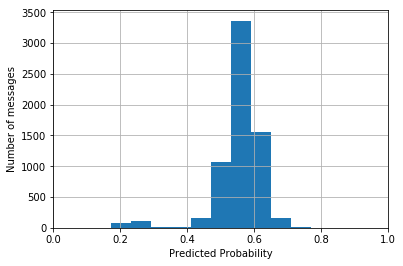

In [23]:
prediction =  logreg.predict(X_x[test])  # logreg.predict(X_x[test])
pr = logreg.predict_proba(X_x[test])           # logreg.predict_proba(X_x[test])
plt.hist(pr[:,0])
plt.xlabel('Predicted Probability')
plt.ylabel('Number of messages')
plt.axis(xmin=0, xmax=1)
plt.grid();

In [24]:
#Let's testing out the predictions
#1. accuracy_score
accuracy_score(y[test], prediction)
#logreg.score(X_test, y_test)

0.5717798954810944

In [30]:
#Let's also do roc-auc-score
roc_auc_score(y[test], pr[:,1])


0.541039718414971

In [ ]:
#K-Fold Validation
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=2652124)
accuracy = []
roc = []
gb_model = sklearn.ensemble.GradientBoostingClassifier()
for train_index, test_index in rkf.split(X_x, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_x[train_index], X_x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    gb_model.fit(X_train, y_train)
    pred = gb_model.predict(X_test)
    accuracy.append(accuracy_score(y_test, pred))  #converting the preditions to 100%
    #roc_auc.append(roc_auc_score(y_test, pred)*100)
    
statistics.mean(accuracy)